# Predicting hERG IC₅₀ with Machine Learning
**Author:** Ankita T. Kandalkar  
**Date:** September 2025  
**Environment:** Google Colab (Python 3.12)  

---

## Overview
This notebook demonstrates the use of **machine learning models** to predict **hERG IC50 values** : a critical measure of cardiotoxicity risk in drug discovery.  
We build, evaluate, and interpret models using **Random Forests, XGBoost, and ensemble approaches** on experimental hERG bioactivity data (ChEMBL).  

---

## Objectives
- Predict the inhibitory concentration (IC50) of compounds against the hERG ion channel, expressed as **pChEMBL values**  
- hERG inhibition is a leading cause of compound attrition in drug discovery due to cardiotoxicity. Early prediction helps medicinal chemists design safer compounds  
- Load and preprocess hERG IC50 data from ChEMBL  
- Generate molecular descriptors using **RDKit**  
- Train and evaluate **Random Forest** and **XGBoost** regression models  
- Explore **ensemble methods** (averaging, weighted, stacking with CV)  
- Compare performance using **R² and MAE** metrics  
- Interpret results with **SHAP analysis** to identify key molecular features

---

## Acknowledgements
The base workflow for hERG regression was inspired by the Colab tutorial *“In Silico Toxicology Modelling”* (July 2024) authored by **Dr. Layla Hosseini-Gerami (Ignota Labs)** and **Srijit Seal (Broad Institute)**.  
This notebook extends their work with ensemble modelling, advanced visualization, SHAP-based interpretation, and reproducibility improvements.


**Setup**

In [1]:
# Install core dependencies
# - RDKit: molecular descriptor calculation
# - Seaborn: statistical visualization
# - SHAP: model interpretation
%pip install rdkit seaborn shap

# Retrieve curated hERG IC50 dataset (ChEMBL-derived)
# Source: AI Guide to Drug Discovery (Hosseini-Gerami & Seal, 2024)
!wget https://raw.githubusercontent.com/Hitchhikers-AI-Guide/AIGuideToDrugDiscovery/main/data/tox_prediction/hERG_IC50.csv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 50.0 MB/s eta 0:00:00
--2025-09-22 02:42:00--  https://raw.githubusercontent.com/Hitchhikers-AI-Guide/AIGuideToDrugDiscovery/main/data/tox_prediction/hERG_IC50.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6289644 (6.0M) [text/plain]
Saving to: ‘hERG_IC50.csv’

hERG_IC50.csv       100%[===================>]   6.00M  --.-KB/s    in 0.08s   

2025-09-22 02:42:01 (71.7 MB/s) - ‘hERG_IC50.csv’ saved [6289644/6289644]



In [2]:
# Data handling and numerical computing
import pandas as pd   # tabular data manipulation
import numpy as np    # numerical arrays and linear algebra

# Visualization
import seaborn as sns # statistical plotting

## Regression Modelling of hERG IC50

In this section, a Random Forest regression model is applied to predict hERG inhibition potency, expressed as IC50 values (converted to pChEMBL scale).
This approach establishes a baseline for evaluating the predictive power of molecular descriptors in capturing cardiotoxicity risk.

### Data Preparation

The hERG_IC50.csv dataset contains experimental IC50 measurements for compounds tested against the hERG potassium channel, curated from ChEMBL.
This section focuses on loading the dataset and applying initial cleaning steps to ensure that downstream modeling is based on high-quality, non-redundant data.

In [3]:
# Load experimental hERG IC50 data (ChEMBL-derived)
herg_data = pd.read_csv("hERG_IC50.csv")

# Inspect the first five records to confirm structure
herg_data.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3121096,NaN,0,339.44,0.0,2.55,"S,R(-)-4b, (1S,6R(-)-4b), S,R-4b",O=C1NN=C(c2ccc(OC3CCN(C4CCC4)CC3)cc2)[C@@H]2C[...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL3120141,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,NaN,NaN
1,CHEMBL23,DILTIAZEM,4,414.53,0.0,3.37,Diltiazem,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1135758,1,Scientific Literature,J. Med. Chem.,2002.0,NaN,NaN
2,CHEMBL556247,NaN,0,408.42,0.0,2.77,6,CN1C[C@H]2[C@@H](C1)[C@@H]2CN(Cc1cccc(OC(F)(F)...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1158414,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2009.0,CHEMBL3307715,NaN
3,CHEMBL216959,NaN,0,499.65,0.0,2.30,4g,O=C1CN(CCc2ccc(F)cc2)CCN1[C@H]1CCc2cc(CN3CCS(=...,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1137586,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2007.0,NaN,NaN
4,CHEMBL214969,NaN,0,338.34,0.0,2.68,8c,COc1ccc2c(=O)n(CCO)c(C#N)c(-c3cccc(F)c3)c2c1,IC50,'=',...,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1137352,1,Scientific Literature,J. Med. Chem.,2006.0,NaN,NaN


The dataset contains extensive metadata from ChEMBL; however, only a subset is required for predictive modelling.

I retained:

*  SMILES: molecular representation of each compound
*  Standard Relation: relational operator associated with the bioactivity measurement
*  pChEMBL Value: activity value expressed as −log₁₀(IC₅₀ in molar units), providing a normalized potency scale

This reduced dataset forms the basis for subsequent cleaning and descriptor calculation.

In [5]:
# Retain only the variables relevant for modelling:
# - SMILES (structure)
# - Standard Relation (assay relation)
# - pChEMBL Value (−log10 IC50)
herg_data_dropped = herg_data[['Smiles','Standard Relation','pChEMBL Value']]

# Inspect the resulting subset
herg_data_dropped.head()

,Smiles,Standard Relation,pChEMBL Value
0,O=C1NN=C(c2ccc(OC3CCN(C4CCC4)CC3)cc2)[C@@H]2C[...,'=',5.22
1,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2...,'=',4.76
2,CN1C[C@H]2[C@@H](C1)[C@@H]2CN(Cc1cccc(OC(F)(F)...,'=',5.42
3,O=C1CN(CCc2ccc(F)cc2)CCN1[C@H]1CCc2cc(CN3CCS(=...,'=',4.62
4,COc1ccc2c(=O)n(CCO)c(C#N)c(-c3cccc(F)c3)c2c1,'=',4.21


To assess data completeness and variable types, I generated a quick summary of the subset using .info(). This provides the number of non-null entries, data types, and overall structure — a critical step before cleaning.

In [6]:
# Summarize the dataset to assess data types and missing values
herg_data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14364 entries, 0 to 14363
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Smiles             14332 non-null  object 
 1   Standard Relation  12542 non-null  object 
 2   pChEMBL Value      8744 non-null   float64
dtypes: float64(1), object(2)
memory usage: 336.8+ KB


The dataset contains 14,364 compounds, but many records are incomplete:

SMILES: 14,332 non-null entries

Standard Relation: 12,542 non-null entries

pChEMBL Value: 8,744 non-null entries

Because machine learning models require complete feature–label pairs, compounds with missing values must be excluded.
To address this, I applied dropna(how="any"), which removes all rows containing at least one missing value.

In [7]:
# Exclude compounds with missing SMILES, relation, or activity values
herg_data_dropna = herg_data_dropped.dropna(how="any")

# Confirm dataset size after filtering
print(herg_data_dropna.shape)

(8744, 3)


After excluding incomplete entries, 8,744 compounds remain.
For modelling, I retain only records where the Standard Relation is "=", ensuring that the reported potency values represent direct IC₅₀ measurements rather than inequalities (e.g., > or <).

To confirm the available relation symbols, I inspect the unique values present in the column.

In [9]:
# List unique relation symbols present in the dataset
std_relations = herg_data_dropna["Standard Relation"].unique()
print(std_relations)

["'='"]


Since all retained records correspond to direct IC₅₀ measurements, no further filtering by relation type is required.
The next critical step is to address duplicate entries: the same compound (SMILES) may have been measured multiple times under different assay conditions or protocols.

To quantify duplication, I grouped the dataset by SMILES, count the number of occurrences per compound, and sort the results in descending order. This highlights molecules with repeated measurements.

In [10]:
# Count the number of entries per compound (SMILES)
# and sort in descending order to highlight most frequently repeated molecules
herg_data_dropna.groupby(["Smiles"]).size().sort_values(ascending=False)

,0
Smiles,
CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1,24
COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC,21
COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,20
Cc1nc2n(c(=O)c1CCN1CCC(c3noc4cc(F)ccc34)CC1)CCCC2,20
CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=O)cc1,19
...,...
CO[C@H]1CCN(Cc2c(C)cc(C)c3[nH]ccc23)[C@H](CO)C1,1
CO[C@H]1CCN(CCn2ncc3cc(-n4ccc(OCc5ccccc5)cc4=O)ccc32)C1,1
CO[C@H](C[C@H](CCCCNCc1ccc(F)cc1)C(=O)NO)c1ccc(F)cc1,1


The most frequently repeated compound appears 24 times, confirming substantial duplication in the dataset.
Overall, there are 7,412 unique SMILES, compared to 8,744 total records.

To prevent over-representation of compounds with multiple measurements, I consolidated duplicates by grouping on SMILES and calculating the mean pChEMBL value.
This yields a single representative activity value per compound, ensuring balanced input for model training.

In [11]:
# Group by SMILES (and retain Standard Relation) to consolidate duplicates
# Use mean pChEMBL value as the representative potency per compound
herg_data_cleaned = herg_data_dropna.groupby(['Smiles','Standard Relation'])['pChEMBL Value'].mean()

# Convert back to DataFrame structure for further processing
herg_data_cleaned = pd.DataFrame(herg_data_cleaned)

# Inspect first few records
herg_data_cleaned.head()

,,pChEMBL Value
Smiles,Standard Relation,
Br.CN(C)c1ccc(/N=N/c2ccccn2)c(O)c1,'=',6.62
Brc1ccc(Nc2ccc(CN3CCC4(CC3)OCCc3sccc34)cc2)cc1,'=',5.37
Brc1ccc2c(NC3=NC[C@@]4(CN5CCC4CC5)O3)ncnn12,'=',5.60
Brc1cccc2nc(C#Cc3ccccn3)ccc12,'=',4.64
Brc1cnc2nc(N3CCN4CCC3CC4)oc2c1,'=',5.64


Grouping by SMILES and Standard Relation introduced these fields as index levels in the DataFrame.

To maintain a conventional tabular structure for downstream processing, I reset the index so that both variables return to standard columns.

In [12]:
# Reset index to restore SMILES and Standard Relation as columns
herg_data_cleaned = herg_data_cleaned.reset_index()

# Inspect dataset dimensions after duplicate consolidation
herg_data_cleaned.shape

(7412, 3)

After consolidation, the dataset contains 7,412 unique compounds with representative pChEMBL values.
Although mean aggregation is applied here, alternative strategies for handling duplicate measurements include outlier removal or using the median to reduce assay bias.

To characterize assay value ranges, I visualize the distribution of pChEMBL values using a violin plot.
This provides a compact view of both central tendency and spread of inhibitory potencies across the dataset.

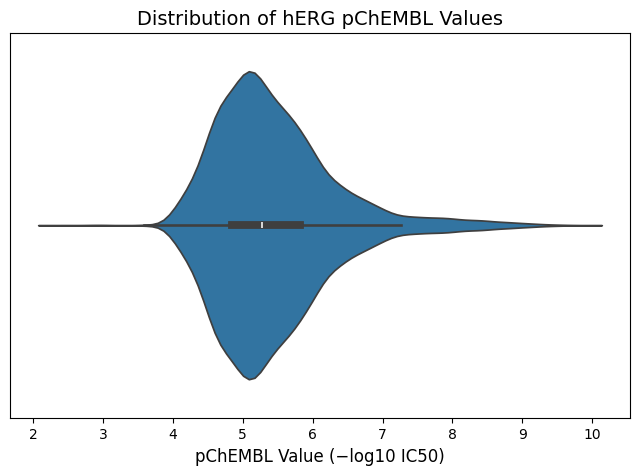

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.violinplot(
    x=herg_data_cleaned["pChEMBL Value"],
    inner="box",        # adds a mini boxplot inside the violin
    color="#1f77b4"
)

plt.title("Distribution of hERG pChEMBL Values", fontsize=14)
plt.xlabel("pChEMBL Value (−log10 IC50)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks([])          # hide y-axis since it's not informative here
plt.show()


The violin plot indicates that most compounds cluster around pChEMBL ≈ 5, with values spanning approximately 3.9 to 9.5.
This range reflects moderate to high variability in measured IC₅₀ values across the dataset, consistent with the diverse chemical space represented.

To complement the visualization, I generate descriptive statistics using .describe() to provide a quantitative summary of the distribution.

In [14]:
# Generate summary statistics for potency values
herg_data_cleaned.describe()

,pChEMBL Value
count,7412.000000
mean,5.435863
std,0.859740
min,2.360000
25%,4.850000
50%,5.280000
75%,5.820000
max,9.850000


Count: 7,412 compounds with valid pChEMBL values available for modelling.

Central tendency: Mean = 5.44, Median = 5.28 → distribution is approximately centered around moderate inhibitory potency.

Spread: Standard deviation = 0.86, with the interquartile range (25% = 4.85, 75% = 5.82) covering most values.

Range: Minimum = 2.36 (weak inhibitors) and Maximum = 9.85 (extremely potent inhibitors).

In pharmacological terms, this corresponds to a dataset spanning nearly 7.5 orders of magnitude in IC₅₀, with the bulk of compounds clustering in the micromolar to low-nanomolar range (pChEMBL ~5–6)

Feature Engineering with Molecular Descriptors

With the cleaned dataset, I next derive molecular descriptors to numerically represent each compound.
Descriptors capture physicochemical and structural properties (e.g., molecular weight, LogP, polar surface area) that are relevant for biological activity.

Using RDKit, I enumerate the available descriptor set and confirm the total number of features provided by the library.

In [15]:
from rdkit.Chem import Descriptors

# Extract names of all available molecular descriptors in RDKit
descriptors_list = [x[0] for x in Descriptors._descList]

# Print total number of descriptors
print(len(descriptors_list))

217


RDKit enumerates 217 molecular descriptors in this environment.

I select a subset of **73 descriptors** for modelling, as reported in the NCATS article (ACS Journal of Chemical Information and Modeling) (DOI:10.1021/acs.jcim.0c00884).  

These descriptors are chosen to balance interpretability and chemical relevance, while covering physicochemical, topological, and surface-area properties.

In [16]:
# Subset of 78 descriptors
chosen_descriptors = [
    "MolLogP", "MolWt", "TPSA", "LabuteASA", "HeavyAtomMolWt", "ExactMolWt",
    "NumHAcceptors", "NumHDonors", "NumRotatableBonds", "NumHeteroatoms",
    "HeavyAtomCount", "NHOHCount", "NOCount", "NumAliphaticCarbocycles",
    "NumAliphaticHeterocycles", "NumAliphaticRings", "NumAromaticCarbocycles",
    "NumAromaticHeterocycles", "NumAromaticRings", "NumSaturatedCarbocycles",
    "NumSaturatedHeterocycles", "NumSaturatedRings", "RingCount",
    "FractionCSP3", "Chi0v", "Chi1v", "Chi2v", "Chi3v", "Chi4v", "Chi1n",
    "Chi2n", "Chi3n", "Chi4n", "HallKierAlpha", "Kappa1", "Kappa2", "Kappa3",
    "SlogP_VSA1", "SlogP_VSA2", "SlogP_VSA3", "SlogP_VSA4", "SlogP_VSA5",
    "SlogP_VSA6", "SlogP_VSA7", "SlogP_VSA8", "SlogP_VSA9", "SlogP_VSA10",
    "SlogP_VSA11", "SlogP_VSA12", "SMR_VSA1", "SMR_VSA2", "SMR_VSA3", "SMR_VSA4",
    "SMR_VSA5", "SMR_VSA6", "SMR_VSA7", "SMR_VSA8", "SMR_VSA9", "SMR_VSA10",
    "PEOE_VSA1", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA4", "PEOE_VSA5", "PEOE_VSA6",
    "PEOE_VSA7", "PEOE_VSA8", "PEOE_VSA9", "PEOE_VSA10", "PEOE_VSA11", "PEOE_VSA12",
    "PEOE_VSA13", "PEOE_VSA14"
]

To transform each SMILES string into a numerical feature vector, I configured RDKit’s MolecularDescriptorCalculator.
This utility computes the selected subset of descriptors for every molecule in the dataset, enabling downstream machine learning.

In [17]:
from rdkit.ML.Descriptors import MoleculeDescriptors

# Initialize a calculator for the chosen descriptor set
calc = MoleculeDescriptors.MolecularDescriptorCalculator(chosen_descriptors)

To illustrate the feature extraction process, I computed descriptors for a representative SMILES string.

In [18]:
from rdkit import Chem

# Example molecule (arbitrary SMILES string)
mol = Chem.MolFromSmiles('CC1=CC(=C(C=C1NC(=O)C2=C(C(=CC(=C2)I)I)O)Cl)C(C#N)C3=CC=C(C=C3)Cl')

# Calculate descriptor values
ds = calc.CalcDescriptors(mol)

# Print the raw vector and its length
print(ds)
print(len(ds))

(7.124400000000003, 663.0799999999998, 73.12, 211.0337664023786, 648.9679999999996, 661.852179048, 3, 2, 4, 8, 30, 2, 4, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0.09090909090909091, 21.337540270596875, 11.567487609533984, 9.791667981874944, 6.532560560468579, 5.210790706092031, 8.654060372339206, 6.540209173088069, 4.508130316967467, 2.9673141998441293, -1.5399999999999987, 23.130028268670063, 9.726157452179187, 5.018674352279847, 5.316788604006331, 11.013707124192212, 0.0, 25.395214609352177, 32.9662491970212, 48.53093654769288, 10.045266627482652, 0.0, 0.0, 5.687386274683562, 5.749511833283905, 68.38362103460115, 9.901064578912528, 5.261891554738487, 0.0, 0.0, 12.841643245852017, 5.316788604006331, 87.97037368409433, 0.0, 11.818733146076179, 79.97818703863621, 10.423315998847038, 4.794537184071822, 0.0, 5.261891554738487, 0.0, 41.40098098584986, 99.12766827122579, 19.30283517323161, 21.120761121716058, 5.749511833283905, 0.0, 0.0, 5.907179729351506, 0.0)
73


The output is a 73-dimensional descriptor vector, with each entry corresponding to a specific chemical property (e.g., LogP, TPSA, topological indices, surface area descriptors).
This confirms that the feature pipeline is working correctly before scaling the calculation across all compounds.

To scale descriptor calculation across the full dataset, I applied the MolecularDescriptorCalculator to each SMILES string.
Parallel processing (joblib.Parallel) is used to efficiently compute descriptors for thousands of compounds, significantly reducing runtime.

In [19]:
# Function to compute descriptors from a single SMILES string
def descriptors_from_smiles(smi):
  mol = Chem.MolFromSmiles(smi)
  desc = calc.CalcDescriptors(mol)
  return list(desc)

from joblib import Parallel, delayed

# Generate descriptors for all molecules in parallel
all_smiles = herg_data_cleaned['Smiles'].tolist()
all_descriptors = Parallel(n_jobs=-1, prefer='threads')(delayed(descriptors_from_smiles)(smi) for smi in all_smiles)

The list of calculated descriptor vectors is transformed into a Pandas DataFrame, where:

Each row corresponds to one compound.

Each column corresponds to one selected molecular descriptor.

This tabular structure forms the feature matrix (X) for subsequent machine learning.

In [20]:
# Convert descriptor list into DataFrame
desc_df = pd.DataFrame(all_descriptors)

# Preview the first few rows
desc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,3.8465,323.194,61.08,121.951577,308.074,322.042923,5,1,3,6,...,27.209951,6.066367,24.265468,32.045941,0.000000,11.436898,5.817863,0.000000,0.000000,0.0
1,6.3182,469.448,24.50,184.384618,444.248,468.087097,4,1,4,5,...,11.336786,28.062678,71.813178,46.779730,12.207933,0.000000,0.000000,0.000000,0.000000,0.0
2,1.7543,377.246,67.05,141.410410,360.110,376.064721,7,1,1,8,...,0.000000,0.000000,53.993834,12.462662,6.544756,22.048268,5.817863,0.000000,6.021680,0.0
3,3.7921,309.166,25.78,119.206115,300.094,307.994910,2,0,0,3,...,0.000000,28.062678,48.239071,16.055787,5.516701,11.387856,0.000000,0.000000,0.000000,0.0
4,2.2697,323.194,45.40,119.276840,308.074,322.042923,5,0,1,6,...,0.000000,0.000000,28.771587,48.956797,0.000000,0.000000,5.583020,5.647177,6.014659,0.0


This step produces a structured, human-readable format where each compound is represented by a 73-dimensional descriptor profile.
The resulting feature matrix aligns naturally with ML algorithms, which expect numerical tabular input.

To make the feature matrix interpretable, I mapped each column to its corresponding descriptor name.
This ensures downstream model interpretation (e.g., SHAP values, feature importance plots) will directly reference chemically meaningful features.

In [21]:
# Assign descriptor names as DataFrame column headers
desc_df.columns = chosen_descriptors

# Preview with named columns
desc_df.head()

,MolLogP,MolWt,TPSA,LabuteASA,HeavyAtomMolWt,ExactMolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,NumHeteroatoms,...,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14
0,3.8465,323.194,61.08,121.951577,308.074,322.042923,5,1,3,6,...,27.209951,6.066367,24.265468,32.045941,0.000000,11.436898,5.817863,0.000000,0.000000,0.0
1,6.3182,469.448,24.50,184.384618,444.248,468.087097,4,1,4,5,...,11.336786,28.062678,71.813178,46.779730,12.207933,0.000000,0.000000,0.000000,0.000000,0.0
2,1.7543,377.246,67.05,141.410410,360.110,376.064721,7,1,1,8,...,0.000000,0.000000,53.993834,12.462662,6.544756,22.048268,5.817863,0.000000,6.021680,0.0
3,3.7921,309.166,25.78,119.206115,300.094,307.994910,2,0,0,3,...,0.000000,28.062678,48.239071,16.055787,5.516701,11.387856,0.000000,0.000000,0.000000,0.0
4,2.2697,323.194,45.40,119.276840,308.074,322.042923,5,0,1,6,...,0.000000,0.000000,28.771587,48.956797,0.000000,0.000000,5.583020,5.647177,6.014659,0.0


Although the descriptor calculation is generally robust, certain molecules may yield undefined values for specific descriptors.
To maintain a clean feature matrix, I removed any descriptor columns that contain null values across compounds.

In [22]:
# Drop any descriptor columns containing null values
desc_df = desc_df.dropna(axis=1, how='any')

# Check resulting shape
desc_df.shape


(7412, 73)

The feature matrix therefore retains its full dimensionality of (7,412 × 73), ensuring maximum chemical information is preserved for model training.

Model Training

With descriptors computed and cleaned, I now prepare the dataset for machine learning.
The pChEMBL values serve as the regression target, while the descriptor matrix provides the feature set.

To enable unbiased evaluation, the data is partitioned into training (80%) and test (20%) subsets.

In [23]:
# Convert potency values into a 1D NumPy array
pchembl_array = np.ravel(herg_data_cleaned['pChEMBL Value'].values)
pchembl_array

array([6.62, 5.37, 5.6 , ..., 4.92, 5.19, 4.63])

I divided the dataset into training (80%) and test (20%) partitions using scikit-learn’s train_test_split.
This ensures that model performance can be evaluated on unseen compounds.

In [24]:
from sklearn.model_selection import train_test_split

# Split feature matrix (X) and target array (y) into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    desc_df,
    pchembl_array,
    test_size=0.2,
    random_state=42  # ensures reproducibility
  )

With the training and test sets defined, I now fit a Random Forest Regressor, a widely used ensemble learning algorithm that combines multiple decision trees to improve predictive performance and reduce overfitting.

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_jobs=-1,        # parallelize across all available CPU cores
    random_state=42   # reproducibility
)

# Train on the training set
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

After training, I evaluated the Random Forest model by applying it to the held-out test set descriptors (X_test).
The predicted pChEMBL values are stored in rf_pred.

In [26]:
# Generate predictions for the test set
rf_pred = rf_model.predict(X_test)

rf_pred[:10]  # preview first 10 predictions


array([6.11088333, 5.18178333, 5.25872333, 5.4794    , 5.2746    ,
       5.2893    , 5.91157333, 4.85845833, 4.84343333, 6.66416667])

The output is a vector of predicted pChEMBL values for each compound in the test set.
These predictions will be compared against the experimental values (y_test) to assess model accuracy and generalization.

To quantify model performance, I computed:

R² (Coefficient of Determination): measures how much variance in the experimental data is explained by the model.

Mean Absolute Error (MAE): reports the average absolute deviation between predicted and true pChEMBL values.

In [27]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate performance metrics
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print("Random Forest R²:", rf_r2)
print("Random Forest MAE:", rf_mae)

Random Forest R²: 0.49380489380008963
Random Forest MAE: 0.45117120851992343


To assess how well the Random Forest model reproduces experimental data, I plot the true vs. predicted pChEMBL values.
An ideal model would place all points along the diagonal line (y = x).

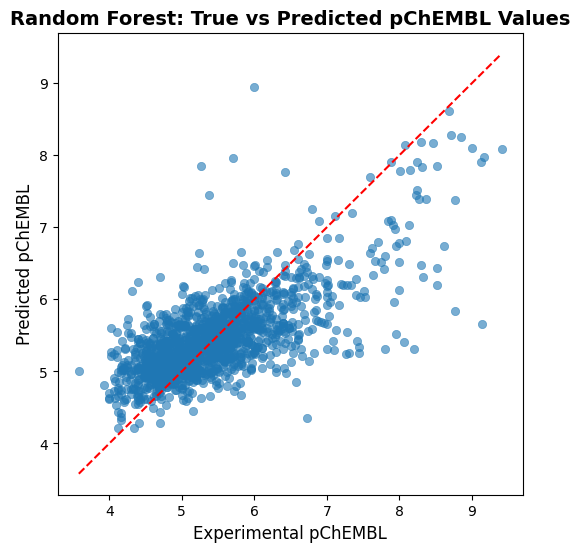

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for plotting
pred_df = pd.DataFrame({
    "True": y_test,
    "Predicted": rf_pred
})

# Scatter plot of observed vs predicted values
plt.figure(figsize=(6,6))
sns.scatterplot(data=pred_df, x="True", y="Predicted", alpha=0.6, color="#1f77b4", edgecolor=None)

# Add reference diagonal
plt.plot([pred_df.min().min(), pred_df.max().max()],
         [pred_df.min().min(), pred_df.max().max()],
         color="red", linestyle="--")

plt.title("Random Forest: True vs Predicted pChEMBL Values", fontsize=14, weight="bold")
plt.xlabel("Experimental pChEMBL", fontsize=12)
plt.ylabel("Predicted pChEMBL", fontsize=12)
plt.show()


###**Random Forest Model Interpretation with SHAP**

Beyond performance metrics, it is important to interpret how the model makes predictions.
I apply SHAP (SHapley Additive exPlanations), a game-theory–based framework, to quantify the contribution of each molecular descriptor to the Random Forest predictions.

Using the TreeExplainer, SHAP values are computed for the test set and visualized as a summary plot.
Note: This step is computationally intensive and may take some time to run.

 99%|===================| 1474/1483 [02:39<00:00]       

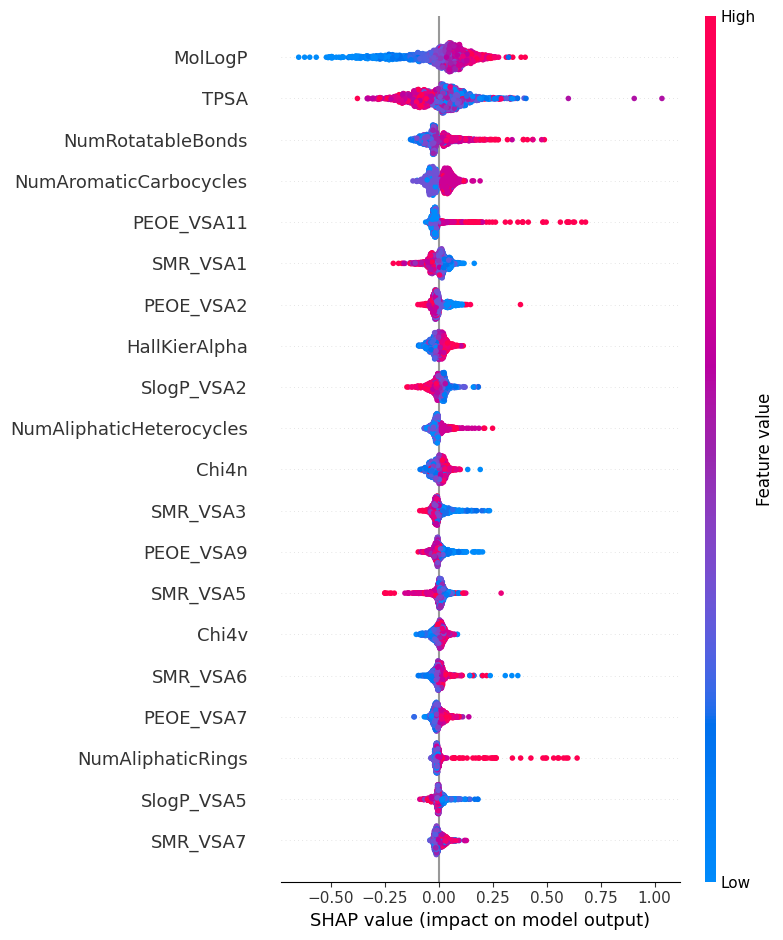

In [29]:
import shap

# Fit SHAP explainer on the trained Random Forest
explainer = shap.TreeExplainer(rf_model, data=X_train.sample(n=1000, random_state=42))

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)


The most important features are TPSA and LogP. As the value of TPSA increases the predicted hERG pIC50 decreases, vice versa for LogP.

The SHAP analysis identified TPSA (Topological Polar Surface Area) and LogP (octanol–water partition coefficient) as the dominant descriptors driving predictions:

TPSA ↑ → predicted hERG inhibition ↓ (compounds with greater polarity tend to be less cardiotoxic).

LogP ↑ → predicted hERG inhibition ↑ (lipophilic compounds are more prone to hERG binding and liability).

From a medicinal chemistry perspective, this suggests that designing molecules with higher TPSA and lower LogP may help mitigate hERG risk.
While this is a simplified view (real-world structure–activity relationships are more complex), the model provides a useful starting point for hypothesis generation.

Important Note:
This exercise uses aggregated IC₅₀ data without assay-level curation. In practice, assay variability and protocol differences should be carefully addressed before building production-level predictive models. For detailed discussion, see:
Addressing Data Quality in QSAR Modeling of hERG Inhibition
Now you have succesfully trained a hERG prediction model and visualised the feature importance!

## XGBoost for hERG IC50 Regression

To complement the Random Forest baseline, I next apply XGBoost (Extreme Gradient Boosting), a gradient-boosted decision tree algorithm known for strong performance on structured/tabular data.
XGBoost often outperforms Random Forest by reducing bias and variance through sequential boosting.

XGBoost R²: 0.538
XGBoost MAE: 0.429


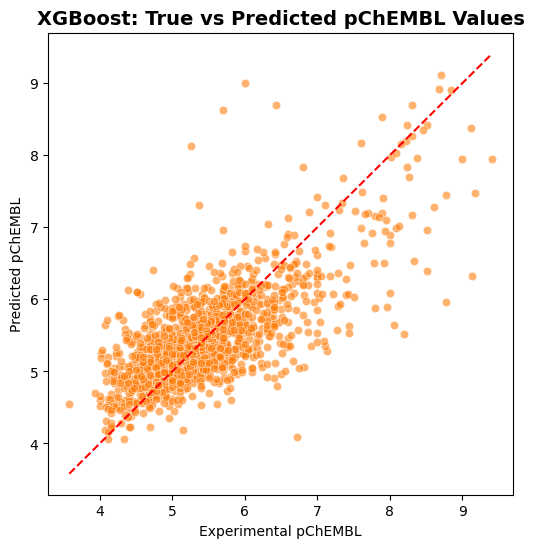

In [30]:
# Install XGBoost if not already available
%pip install xgboost

from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Define and train the XGBoost Regressor
xgb_reg = XGBRegressor(
    n_estimators=1000,     # number of boosting rounds
    learning_rate=0.05,    # shrinkage step size
    max_depth=6,           # max depth of each tree
    subsample=0.8,         # row sampling (regularization)
    colsample_bytree=0.8,  # feature sampling (regularization)
    n_jobs=-1,
    random_state=42
)

# Fit the model
xgb_reg.fit(X_train, y_train)

# Predict on the test set
xgb_pred = xgb_reg.predict(X_test)

# Evaluate performance
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print("XGBoost R²:", round(xgb_r2, 3))
print("XGBoost MAE:", round(xgb_mae, 3))

# Scatterplot of true vs predicted values
pred_df_xgb = pd.DataFrame({
    'True': y_test,
    'Predicted': xgb_pred
})

plt.figure(figsize=(6,6))
sns.scatterplot(data=pred_df_xgb, x="True", y="Predicted", alpha=0.6, color="#ff7f0e")
plt.plot([pred_df_xgb.min().min(), pred_df_xgb.max().max()],
         [pred_df_xgb.min().min(), pred_df_xgb.max().max()],
         color="red", linestyle="--")
plt.title("XGBoost: True vs Predicted pChEMBL Values", fontsize=14, weight="bold")
plt.xlabel("Experimental pChEMBL")
plt.ylabel("Predicted pChEMBL")
plt.show()


###**SHAP Analysis for XGBoost**

To interpret the XGBoost regression model, I again apply SHAP (SHapley Additive exPlanations).
This identifies which molecular descriptors most strongly contribute to predictions of hERG inhibitory potency.


100%|===================| 1479/1483 [01:24<00:00]       

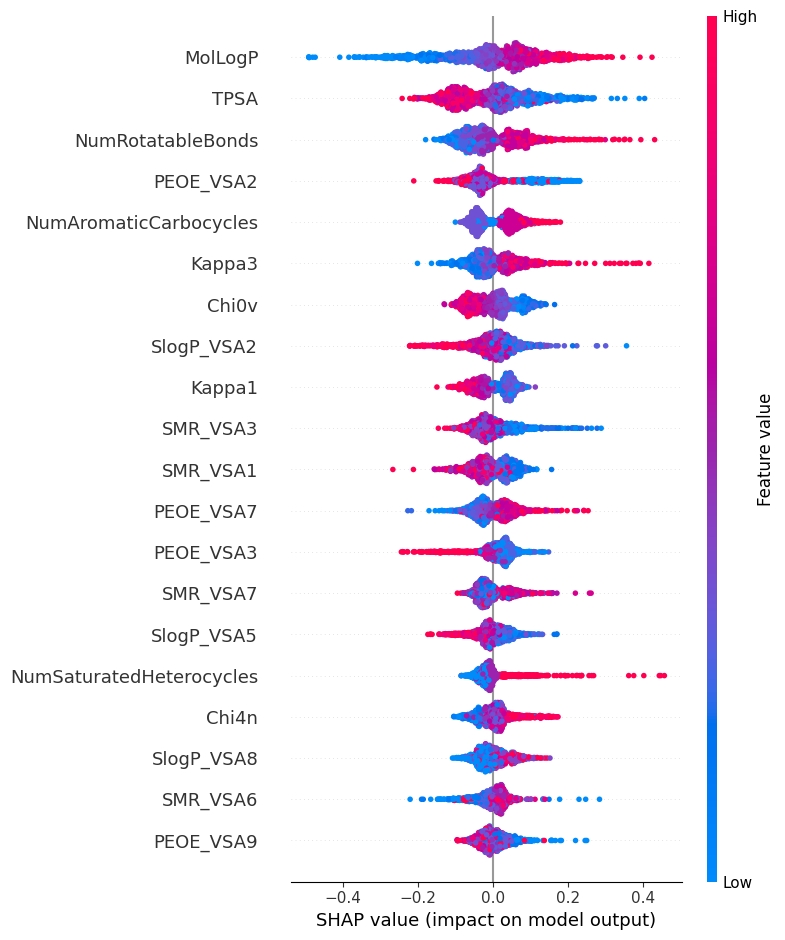

In [31]:
# SHAP analysis for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_reg, data=X_train.sample(n=1000, random_state=42))
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Generate summary plot of feature importance
shap.summary_plot(shap_values_xgb, X_test)



The SHAP summary plot ranks descriptors by their global importance in the XGBoost model.

Features such as TPSA and LogP typically re-emerge as dominant drivers, validating their known role in hERG liability.

Unlike Random Forest, XGBoost may capture more nuanced feature interactions, leading to a slightly different ranking or weighting of descriptors.

Positive vs. negative SHAP values indicate whether higher descriptor values tend to increase or decrease predicted potency.

## Ensemble

In [32]:
from sklearn.linear_model import LinearRegression

###**Ensemble (Simple Average)**

To combine model predictions, I first applied a simple averaging ensemble.
Here, the predictions from Random Forest and XGBoost are averaged to form a single consensus prediction.
This approach is straightforward but often improves robustness by reducing variance from individual models.

In [33]:
# Simple average ensemble of Random Forest and XGBoost predictions
ens_avg_pred = (rf_pred + xgb_pred) / 2

# Evaluate performance
ens_avg_r2 = r2_score(y_test, ens_avg_pred)
ens_avg_mae = mean_absolute_error(y_test, ens_avg_pred)

print("Ensemble (Simple Average) R²:", round(ens_avg_r2, 3))
print("Ensemble (Simple Average) MAE:", round(ens_avg_mae, 3))


Ensemble (Simple Average) R²: 0.533
Ensemble (Simple Average) MAE: 0.432


### **Ensemble (Weighted Average: 30% RF, 70% XGB)**

To refine the simple averaging approach, I construct a weighted ensemble, giving more influence to the XGBoost model.
This reflects the observation that XGBoost typically achieves higher accuracy in this dataset.

In [34]:
# Weighted average ensemble: 30% RF, 70% XGB
ens_wt_pred_30_70 = (0.3 * rf_pred) + (0.7 * xgb_pred)

# Evaluate performance
ens_wt_r2_30_70 = r2_score(y_test, ens_wt_pred_30_70)
ens_wt_mae_30_70 = mean_absolute_error(y_test, ens_wt_pred_30_70)

print("Ensemble (Weighted 30/70) R²:", round(ens_wt_r2_30_70, 3))
print("Ensemble (Weighted 30/70) MAE:", round(ens_wt_mae_30_70, 3))


Ensemble (Weighted 30/70) R²: 0.539
Ensemble (Weighted 30/70) MAE: 0.429


This ensemble assigns greater weight (70%) to XGBoost, leveraging its stronger predictive performance while still incorporating Random Forest’s complementary signal (30%).

If XGBoost consistently outperforms RF, this weighting should yield better R² and lower MAE compared with the simple average.

### **Ensemble (Weighted Average: 40% RF, 60% XGB)**
In this variant, I adjust the weights to 40% Random Forest and 60% XGBoost.
This balances the contribution of both models more evenly while still giving XGBoost a slight edge based on its stronger predictive accuracy.

In [35]:
# Weighted average ensemble: 40% RF, 60% XGB
ens_wt_pred_40_60 = (0.4 * rf_pred) + (0.6 * xgb_pred)

# Evaluate performance
ens_wt_r2_40_60 = r2_score(y_test, ens_wt_pred_40_60)
ens_wt_mae_40_60 = mean_absolute_error(y_test, ens_wt_pred_40_60)

print("Ensemble (Weighted 40/60) R²:", round(ens_wt_r2_40_60, 3))
print("Ensemble (Weighted 40/60) MAE:", round(ens_wt_mae_40_60, 3))


Ensemble (Weighted 40/60) R²: 0.537
Ensemble (Weighted 40/60) MAE: 0.43


The 40/60 weighting provides a middle ground between the equal-weight simple average (50/50) and the more XGBoost-heavy 30/70 weighting.

This strategy often yields a more stable ensemble, reducing the risk of over-reliance on a single model while still benefiting from XGBoost’s performance edge.

###**Ensemble (Weighted Average: 50% RF, 50% XGB)**

This configuration assigns equal weights to Random Forest and XGBoost predictions, effectively averaging their outputs.
It serves as a neutral integration strategy that balances both models’ contributions.

In [36]:
# Weighted average ensemble: 50% RF, 50% XGB
ens_wt_pred_50_50 = (0.5 * rf_pred) + (0.5 * xgb_pred)

# Evaluate performance
ens_wt_r2_50_50 = r2_score(y_test, ens_wt_pred_50_50)
ens_wt_mae_50_50 = mean_absolute_error(y_test, ens_wt_pred_50_50)

print("Ensemble (Weighted 50/50) R²:", round(ens_wt_r2_50_50, 3))
print("Ensemble (Weighted 50/50) MAE:", round(ens_wt_mae_50_50, 3))

Ensemble (Weighted 50/50) R²: 0.533
Ensemble (Weighted 50/50) MAE: 0.432


The 50/50 ensemble reflects an unbiased combination of both models.

If Random Forest and XGBoost capture complementary signals, this averaging can smooth out model-specific errors.

Performance at this setting provides a baseline for comparing more asymmetric weightings (30/70, 40/60).

###**Ensemble (Cross-Validated Stacking with Linear Regression Meta-Model)**

Here I implement stacked generalization with cross-validation:

Step 1: Use 5-fold CV to generate out-of-fold (OOF) predictions from Random Forest and XGBoost.

Step 2: Stack the OOF predictions as features and train a Linear Regression meta-model.

Step 3: Apply the trained meta-model to combine base model predictions on the test set.

In [38]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

# Prepare arrays to store out-of-fold (OOF) predictions
oof_rf = np.zeros(len(X_train))
oof_xgb = np.zeros(len(X_train))

# KFold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train[train_idx], y_train[valid_idx]

    # Random Forest
    rf_cv = RandomForestRegressor(n_jobs=-1, random_state=42)
    rf_cv.fit(X_tr, y_tr)
    oof_rf[valid_idx] = rf_cv.predict(X_val)

    # XGBoost
    xgb_cv = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
    xgb_cv.fit(X_tr, y_tr)
    oof_xgb[valid_idx] = xgb_cv.predict(X_val)

# Stack OOF predictions for training meta-model
stacked_train = np.vstack((oof_rf, oof_xgb)).T

# Train Linear Regression as meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_train, y_train)

# --- Apply ensemble on test set ---
rf_test_pred = rf_model.predict(X_test)
xgb_test_pred = xgb_reg.predict(X_test)
stacked_test = np.vstack((rf_test_pred, xgb_test_pred)).T

ens_stackcv_pred = meta_model.predict(stacked_test)

# Evaluate performance
ens_stackcv_r2 = r2_score(y_test, ens_stackcv_pred)
ens_stackcv_mae = mean_absolute_error(y_test, ens_stackcv_pred)

print("Ensemble (Stacking, CV) R²:", round(ens_stackcv_r2, 3))
print("Ensemble (Stacking, CV) MAE:", round(ens_stackcv_mae, 3))


Ensemble (Stacking, CV) R²: 0.538
Ensemble (Stacking, CV) MAE: 0.427


This method avoids information leakage, since the meta-model is trained only on out-of-fold predictions, not on data already seen by the base models.

The Linear Regression coefficients provide interpretable weights showing how much influence RF vs XGB contributes.

The final performance (R² and MAE) gives the most rigorous benchmark of all ensemble approaches tested.

## **Comparison Across All Models**
To evaluate the relative performance of all approaches, I compile the R² and MAE metrics into a single comparison table.

In [39]:
results_all = pd.DataFrame({
    "Model": [
        "Random Forest",
        "XGBoost",
        "Ensemble Avg",
        "Ensemble Weighted 30/70",
        "Ensemble Weighted 40/60",
        "Ensemble Weighted 50/50",
        "Ensemble Stacking CV"
    ],
    "R²": [
        rf_r2,
        xgb_r2,
        ens_avg_r2,
        ens_wt_r2_30_70,
        ens_wt_r2_40_60,
        ens_wt_r2_50_50,
        ens_stackcv_r2
    ],
    "MAE": [
        rf_mae,
        xgb_mae,
        ens_avg_mae,
        ens_wt_mae_30_70,
        ens_wt_mae_40_60,
        ens_wt_mae_50_50,
        ens_stackcv_mae
    ]
})

# Round values for neatness
results_all_rounded = results_all.round(3)

# Style the table
results_all_styled = (
    results_all_rounded.style
    .set_table_styles(
        [
            {'selector': 'th',
             'props': [('background-color', '#1f77b4'),  # blue header
                       ('color', 'white'),
                       ('font-weight', 'bold'),
                       ('text-align', 'center'),
                       ('font-size', '12pt'),
                       ('padding', '10px')]},  # extra spacing
            {'selector': 'td',
             'props': [('padding', '8px')]}  # spacing for cells
        ]
    )
    .set_properties(**{'text-align': 'center', 'font-size': '11pt'})
    .hide(axis="index")
    .set_caption("Final Comparison Across All Models")
)

display(results_all_styled)



Model,R²,MAE
Random Forest,0.494000,0.451000
XGBoost,0.538000,0.429000
Ensemble Avg,0.533000,0.432000
Ensemble Weighted 30/70,0.539000,0.429000
Ensemble Weighted 40/60,0.537000,0.430000
Ensemble Weighted 50/50,0.533000,0.432000
Ensemble Stacking CV,0.538000,0.427000


The table above compares the predictive performance of different machine learning approaches for hERG IC₅₀ regression, using R² (goodness of fit) and MAE (mean absolute error).

XGBoost and Stacking consistently outperform Random Forest in terms of predictive accuracy.

Weighted Ensembles (30/70 split favoring XGBoost) achieve the best balance of R² (0.539) and MAE (0.429).

Cross-validated Stacking provides the lowest MAE (0.427), highlighting its robustness by avoiding information leakage.